## Two tones suppress effect

In [1]:
%matplotlib widget

import synchrony as sync

import matplotlib
# %matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np
from scipy import stats as sps 
import numpy.fft as ft
from scipy import signal as sig
from scipy import io
import scipy.io.wavfile as wav
#from scipy.linalg import toeplitz
from math import *
from random import randrange, uniform

from threading import Event


%load_ext autoreload
%autoreload 2

### Synchronic representation definition

Both filter and PLL follows the same design as in the tuning curve experiment. 
See at the final blocks for a graph of the tuning curve with indicated coordinates used in this experiment.
Three short duration disturbing stimuli are presented added to a permanent tone stimulus. See the discussion of the phenomena after code.

In [2]:
# Filter order
N = 2048
# Sampling frequency
Fs = 16000;
fz = 2000.
df = 50./log(sqrt(2))
# fp_minus_fz = 10.*np.log(2.)/np.log(np.sqrt(2.))
fp_minus_fz = .1*np.log(2.)/np.log(np.sqrt(2.))
print('Cutoff freq fz = {}'.format(fz))
print('Peak frequency distance to cutoff = {}'.format(fp_minus_fz))
print('Band width = {}'.format(df))
#Discrete time filter impulsive response:
hn = sync.hn_cochlear(N,Fs,df,fz,fp_minus_fz)


# One second of input signal
ltime = int(Fs)
y = np.empty((1,ltime))
t = np.linspace(0,ltime/Fs,ltime,endpoint=False)

# Constant level stimulus (permanent tone):
f1 = 1925 #close to characteristic freq.
A1 = 1/(2**6) #-6dB
x1 = A1*np.sin(2*pi*f1*t);

# Suppressor (masking) frequency stimuli:
f2 = np.array([1650.,1880., 2200.])
A2 = 1/2 #-1dB
tmpwin = np.zeros(len(t))
Nhann = 65
where_win1 = np.where((t>0.4) & (t<0.45))[0]
tmpwin[where_win1] = np.ones(len(where_win1))
win = sig.lfilter(np.hanning(Nhann)/(Nhann-1)*2.,[1.],tmpwin)


Cutoff freq fz = 2000.0
Peak frequency distance to cutoff = 0.19999999999999996
Band width = 144.26950408889633


freq = 1650.0


/tmp/ipykernel_15117/1572747366.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  y[0,:] = sig.lfilter(hn,[1.],x1+x2);
/tmp/ipykernel_15117/1572747366.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=2)
/tmp/ipykernel_15117/1572747366.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
/home/ppelle/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


freq = 1880.0
freq = 2200.0


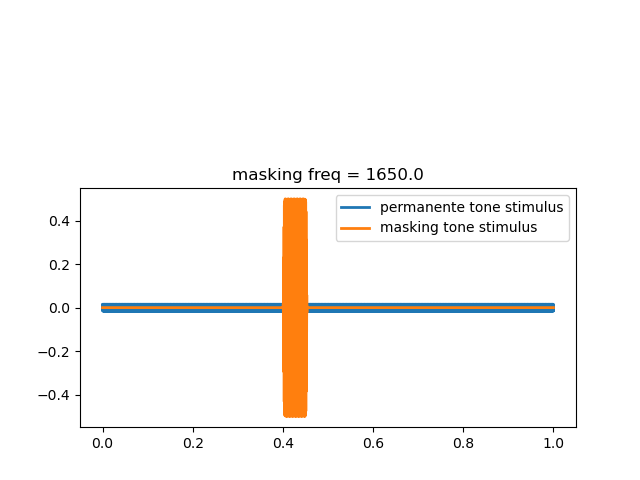

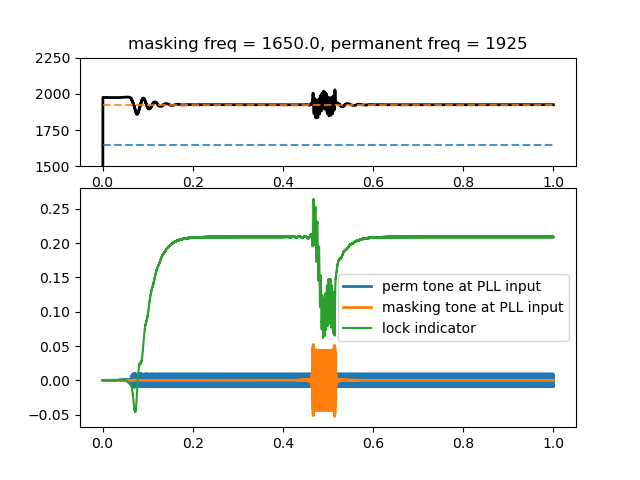

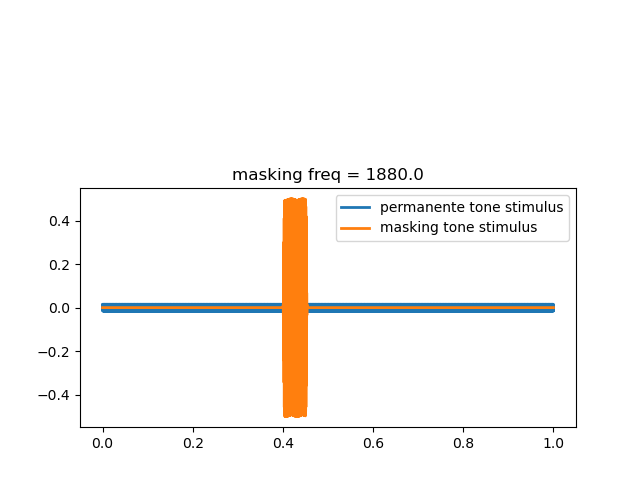

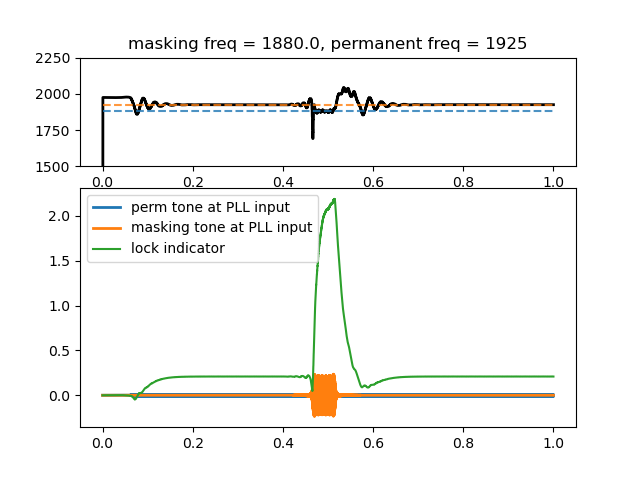

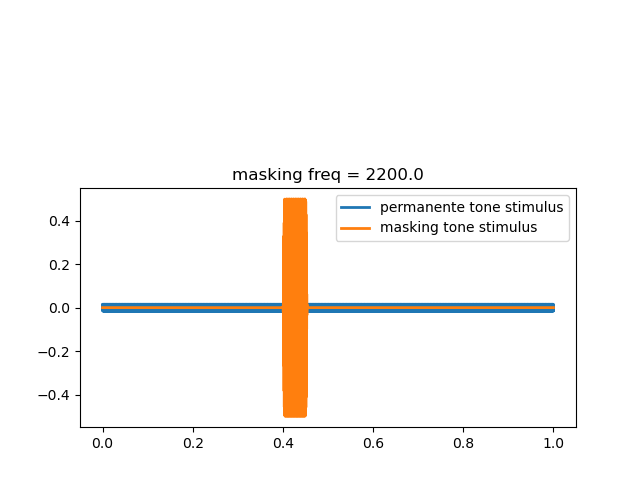

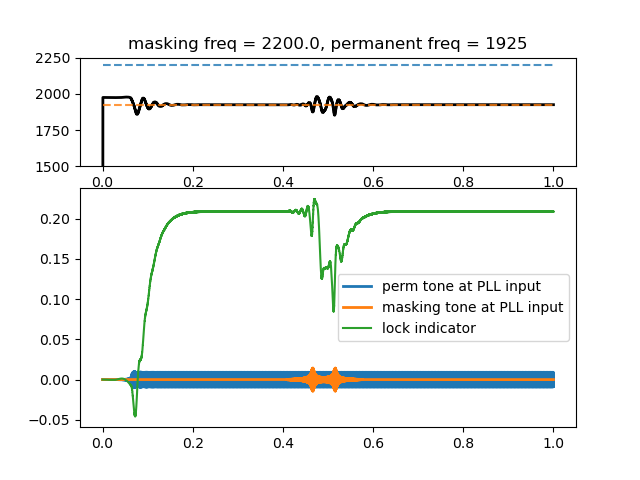

In [3]:
# Plots for the three cases:
# - First figure: plot of the permanent and masking stimuli
# - Second figure: 
#   + Upper part: detected PLL frequency; also in dotted line permanent and masking frequencies
#   + Lower part: Filtered tones at PLL input, and lock indicator signal
gridsize = (3,1)

for k in range(len(f2)):
    print('freq = {}'.format(f2[k]))
    x2 = A2*np.sin(2*pi*f2[k]*t)*win
    y2 = sig.lfilter(hn,[1.],x2);
    y1 = sig.lfilter(hn,[1.],x1);
    y[0,:] = sig.lfilter(hn,[1.],x1+x2);

    # PLL initialization
    pll = sync.bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=16000)
    pll.section_calc(y)
#     lockf = 0.25*sig.lfilter(np.hanning(Nhann),[1.],np.array(list(pll.lock[0,:])+ [0.]*int((Nhann-1)/2)));
    
    fig = plt.subplots()
    gridsize = (3,1)
    ax1 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=2)
#     ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=2)
    
    ax1.plot(t,x1,lw=2,label='permanente tone stimulus')
    ax1.plot(t,x2,lw=2,label='masking tone stimulus')
    ax1.set_title('masking freq = {}'.format(f2[k]))
    ax1.set_ylim(-0.55,0.55)
    ax1.legend()
#     legend('permanent tone in','masking tone in','Location','best')
#     xlabel('t(sec)','fontsize',9,'fontangle','italic')

    fig,ax3 = plt.subplots()
    ax3 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
    ax4 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=2)

    ax3.plot(t,pll.freq[0,:],'k',lw=2,label='estimated freq')
    ax3.plot([t[0],t[-1]],f2[k]*np.array([1.,1.]),color='C0',ls='--', alpha=0.8,label='perm tone freq')
    ax3.plot([t[0],t[-1]],f1*np.array([1.,1.]),color='C1',ls='--', alpha=0.8,label='mask tone freq')
    ax3.set_ylim(1500,2250)
#     xlabel('t(sec)','fontsize',9,'fontangle','italic')
#     ylabel('freq(t)','fontsize',9,'fontangle','italic')
    ax3.set_title('masking freq = {}, permanent freq = {}'.format(f2[k],f1))

    ax4.plot(t,y1,lw=2,label='perm tone at PLL input')
    ax4.plot(t,y2,lw=2,label='masking tone at PLL input')
#     ax4.plot(t,lockf[int((Nhann-1)/2):])
    ax4.plot(t,5*pll.lock[0,:],label='lock indicator')
    ax4.legend()
#     %legend('out1','masking out','lockin','Location','SouthWest')
#     legend('permanent out','masking out','lockin','Location','SouthWest')
#     a = axis;
#     axis([a(1:2) -0.1 0.1])
#     pause(0.05);
#     xlabel('t(sec)','fontsize',9,'fontangle','italic')
#     %ylabel('Amplitud (dB)','fontsize',9,'fontangle','italic')



#### Discusion

First and third cases correspond to zones of masking effect as shown by the experimental evidence. Both masking effects are due to a different phenomena in the synchronic representation, as explained below.

In the first case, when the masking tone is presented it can be observed a clear lack of lock, as indicated in the green line (low graph, fig2). This effect can be explained because the masking tone filter output has a considerable amplitud compared to the permanent one, that is pulling the PLL from its permanent tone frequency towards this new frequency. But no acquisition is achieved because presentation time is too short to change this previous energized condition. After the masking tone has disappeared, the previous condition is restored. 

In the second case, the effective masking tone input to the PLL has higher energy and is closer in frequency to the permanent tone than in the previous case. As a consequence, acquisition is achieved for the brief time lapse the masking stimulus is presented, and the masking phenomenum does not appear. 

Lastly, in the third case, the filtered masking stimulus has very low energy except for the transient part, i. e. the onset and offset of the masking tone. Nevertheless, due to the impulsive filter response, these two disturbances still posses enough energy to pull the PLL from its permanent state, displaying a transient lack of lock during a brief time.   

Following figure displays coordinates for the three masking and permanent tones.

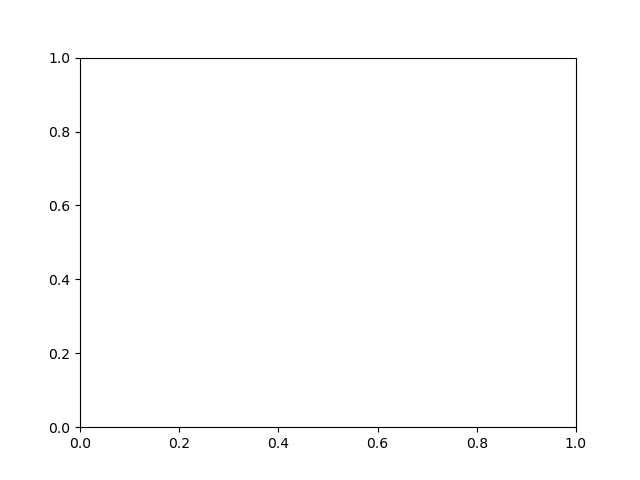


A = 1.000000
f = 2196.875000
A = 0.500000
f = 2196.875000
A = 0.250000
f = 2196.875000
A = 0.125000
f = 2196.875000
A = 0.062500
f = 2196.875000
A = 0.031250
f = 2196.875000
A = 0.015625
f = 2196.875000
A = 0.007812
f = 2196.875000
A = 0.003906
f = 2196.875000
A = 0.001953
f = 2196.875000
A = 0.000977
f = 2196.875000
A = 0.000488
f = 2196.875000
A = 0.000244
f = 2196.875000
A = 0.000122
f = 2196.875000

In [5]:
fig,ax = plt.subplots()
fig.canvas.draw()
plt.show(block=False)

Ncont = 2**14
ftun = np.arange(1400.,2200.,Fs/Ncont*16.)
A = np.array([1, 0.5, 0.25, 0.125, 1./16., 1./32., 1./64., 1./128., 1./256., 1./512., 1./1024., 1./2048., 1./4096., 1./8192.])
lockmean = np.empty((len(ftun),len(A)))
si = 0
no = 0
for p in range(len(A)):
    print('\nA = {:f}'.format(A[p]))
    for k in range(len(ftun)):
        print('\rf = {:f}'.format(ftun[k]),end='')
        s = A[p]*np.sin(2*np.pi*ftun[k]*t)
        y[0,:] = sig.lfilter(np.real(hn),[1.],s)
        pll = sync.bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=16000)
        pll.section_calc(y)
        #Check lockin after transit time of cochlear filter:
        lockmean[k,p] = np.mean(pll.lock[0,int(N*1.1):])
        if(lockmean[k,p]>0.0005):
            hsi, = ax.plot(ftun[k],np.log(A[p])/np.log(2.),'r*',label='Acquisition' if si == 0 else '_nolenged_')
            si = 1
        else:
            hno, = ax.plot(ftun[k],np.log(A[p])/np.log(2.),'b.',label='no lock' if no == 0 else '_nolenged_')
            no = 1
        ax.relim() 
        ax.autoscale_view(True,True,True) 
        fig.canvas.draw()

In [7]:
no = 0
for f in f2:
    h, = ax.plot(f,np.log(A2)/np.log(2.),marker='o',mec='darkgreen',ms=10,\
                 mfc='none',markeredgewidth=2, ls='',label='Masking freq.' if no == 0 else '_nolegend_')
    no = 1
h, = ax.plot(f1,np.log(A1)/np.log(2.),marker='o',mec='darkred',ms=10,\
                mfc='none',markeredgewidth=2, ls='',label='Permanent freq.')
ax.legend()    